In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patchworklib as pw
import seaborn as sns
import xarray as xr
from data_utils import get_gfp_peaks
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from tqdm import tqdm

plt.style.use("papers")
plt.rcParams.update(
    {
        "axes.facecolor": "white",
        "figure.facecolor": "white",
        "savefig.facecolor": "white",
    }
)
pw.overwrite_axisgrid()

FOLDER = "../../results/20220914_random_data_stuff_200subjects_20channels_4states_hmm_GFP_no_envelope_noPCA"

<Figure size 72x72 with 0 Axes>

In [2]:
data = pd.read_csv(
    os.path.join(FOLDER, "data_and_segmentation.csv"), index_col=[0, 1]
).rename(columns={"kmeans": "mod. K-Means"})
stats = pd.read_csv(os.path.join(FOLDER, "basic_stats.csv"), index_col=0)
dynstats = pd.read_csv(os.path.join(FOLDER, "dyn_stats.csv"), index_col=0)
maps = xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))

In [3]:
COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]
data_for_corr = data.iloc[:, 20:].loc[:, COLUMNS_ORDER]
data_for_corr = data_for_corr.groupby("subject").corr("spearman").unstack()

In [4]:
data.iloc[:, 20:].loc[:, COLUMNS_ORDER]

AAHC  TAAHC  mod. K-Means  HMM  PCA  ICA
subject         time                                           
rnd_subject_3   0.000     1      3             3    1    0    1
                0.004     1      0             2    2    0    1
                0.008     0      2             2    2    3    3
                0.012     2      1             2    2    1    1
                0.016     2      1             3    2    0    1
...                     ...    ...           ...  ...  ...  ...
rnd_subject_199 9.980     0      2             2    0    3    1
                9.984     0      1             1    0    1    1
                9.988     0      0             2    0    3    1
                9.992     2      3             1    0    3    2
                9.996     2      3             0    0    3    3

[500000 rows x 6 columns]

In [5]:
data.iloc[:, 20:].loc[:, COLUMNS_ORDER].groupby("subject").corr(
    "spearman"
).unstack().mean()

AAHC          AAHC            1.000000
              TAAHC           0.056058
              mod. K-Means    0.019793
              HMM             0.001173
              PCA            -0.008884
              ICA             0.010935
TAAHC         AAHC            0.056058
              TAAHC           1.000000
              mod. K-Means    0.005930
              HMM            -0.003198
              PCA             0.000002
              ICA            -0.017234
mod. K-Means  AAHC            0.019793
              TAAHC           0.005930
              mod. K-Means    1.000000
              HMM             0.001341
              PCA            -0.013735
              ICA            -0.016326
HMM           AAHC            0.001173
              TAAHC          -0.003198
              mod. K-Means    0.001341
              HMM             1.000000
              PCA             0.002826
              ICA            -0.000156
PCA           AAHC           -0.008884
              TAAHC      

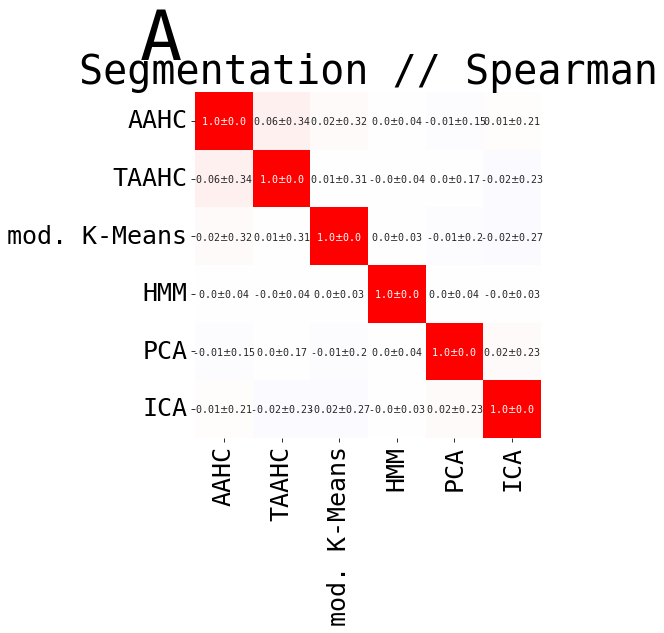

In [6]:
segm_mean = (
    data_for_corr.mean()
    .reset_index()
    .pivot(index="level_0", columns="level_1")
    .loc[COLUMNS_ORDER, (0, COLUMNS_ORDER)]
)
segm_mean.index.name = ""
segm_mean.columns = segm_mean.columns.get_level_values(1)
segm_mean.columns.name = ""

segm_std = (
    data_for_corr.std()
    .reset_index()
    .pivot(index="level_0", columns="level_1")
    .loc[COLUMNS_ORDER, (0, COLUMNS_ORDER)]
)
segm_std.index.name = ""
segm_std.columns = segm_std.columns.get_level_values(1)
segm_std.columns.name = ""

g1 = pw.Brick("ax0", figsize=(6, 6))
sns.heatmap(
    segm_mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=segm_mean.round(2).astype(str) + "$\pm$" + segm_std.round(2).astype(str),
    fmt="",
    ax=g1,
)
g1.set_title("Segmentation // Spearman")
g1.text(
    -0.1,
    1.15,
    "A",
    ha="center",
    va="center",
    transform=g1.transAxes,
    fontsize=70,
)
g1.savefig(quick=True)
# mean = prep.
# std = prep.std(ddof=1).reset_index().pivot(index="level_0", columns="level_1")

In [7]:
# rcorrs = data[data.columns[3:]].corr("spearman")
# np.fill_diagonal(rcorrs.values, np.nan)
# g7 = pw.Brick("ax54", figsize=(3, 3))
# sns.heatmap(
#     rcorrs,
#     square=True,
#     vmax=1.0,
#     vmin=-1,
#     cmap="bwr",
#     annot=data[data.columns[3:]].rcorr("spearman", padjust="fdr_by", decimals=2),
#     fmt="",
#     annot_kws={"fontsize": 14},
#     ax=g7,
# )
# g7.set_title("Segmentation // Spearman")
# # g7 = pw.load_seaborngrid(g)
# display(data[data.columns[3:]].rcorr("spearman", padjust="fdr_by"))

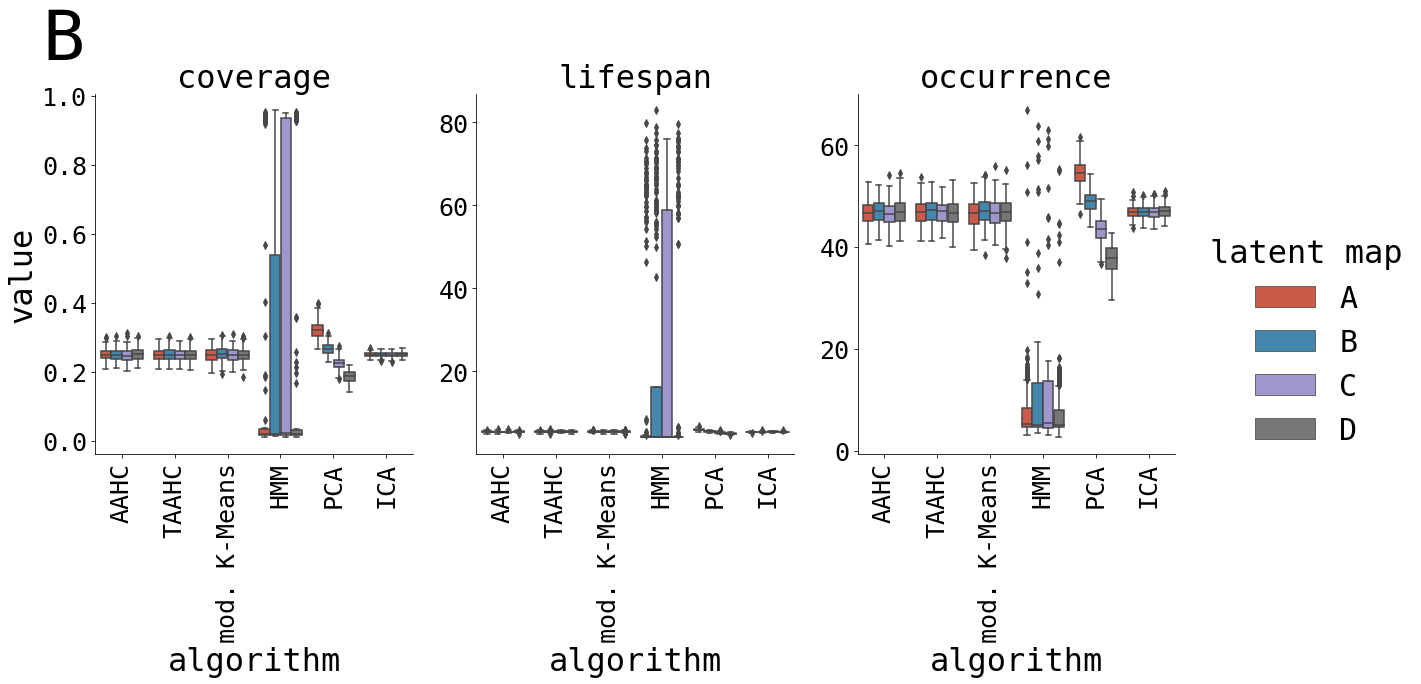

In [8]:
stats = (
    stats.replace({"kmeans": "mod. K-Means"})
    .rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
)
stats_melt = stats.melt(
    id_vars=["algorithm", "latent map"],
    value_vars=["coverage", "lifespan", "occurrence"],
)
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    hue="latent map",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0][0].text(
    -0.1,
    1.15,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g2 = pw.load_seaborngrid(g)
g2.savefig(quick=True)

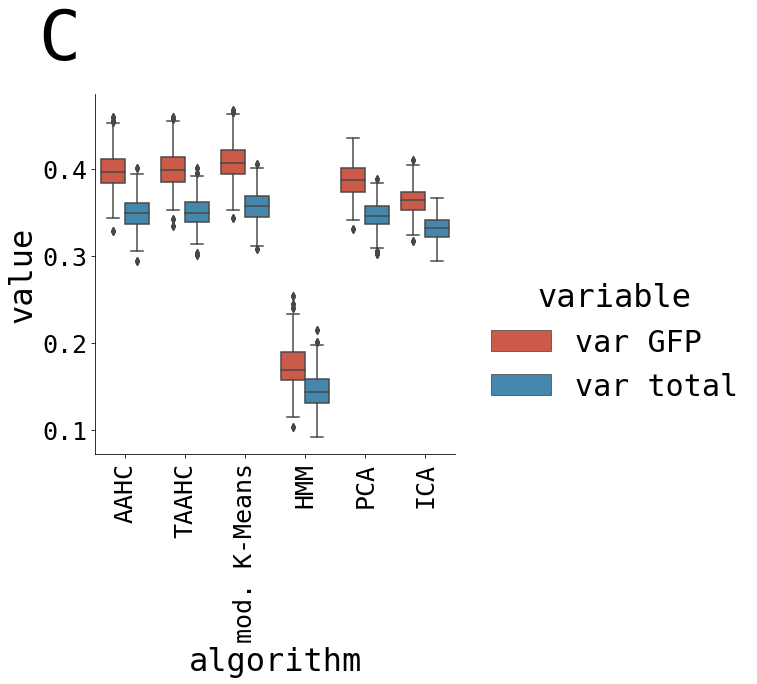

In [9]:
g = sns.catplot(
    data=stats.melt(id_vars="algorithm", value_vars=["var GFP", "var total"]),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)

g3 = pw.load_seaborngrid(g)
g3.savefig(quick=True)

In [10]:
dynstats

,algorithm,subject,mixing time,entropy,max entropy,entropy rate,MC entropy rate,AIF 1st peak
0,PCA,rnd_subject_3,1.039289,1.943764,2.0,1.757230,1.941968,52.0
1,ICA,rnd_subject_3,1.036101,1.999942,2.0,1.782769,1.998699,36.0
2,kmeans,rnd_subject_3,0.997650,1.999727,2.0,1.795953,1.998412,36.0
3,AAHC,rnd_subject_3,1.028293,1.998913,2.0,1.796093,1.996742,40.0
4,TAAHC,rnd_subject_3,1.040536,1.997815,2.0,1.788101,1.996427,48.0
...,...,...,...,...,...,...,...,...
1,ICA,rnd_subject_199,1.043721,1.999704,2.0,1.786767,1.997707,44.0
2,kmeans,rnd_subject_199,1.057616,1.998213,2.0,1.786763,1.994843,52.0
3,AAHC,rnd_subject_199,1.025574,1.986920,2.0,1.788646,1.984797,52.0
4,TAAHC,rnd_subject_199,1.061621,1.992717,2.0,1.787797,1.989531,40.0


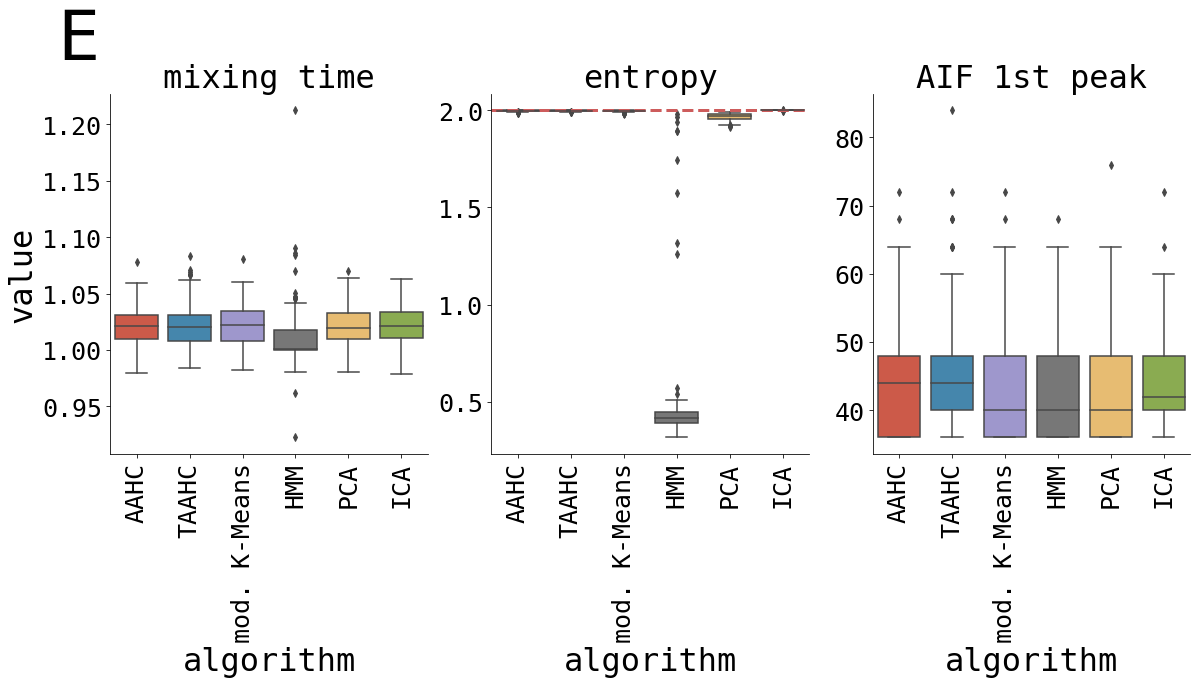

In [11]:
dynstats_melt = (
    dynstats.replace({"kmeans": "mod. K-Means"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["mixing time", "entropy", "AIF 1st peak"],
    )
)
g = sns.catplot(
    data=dynstats_melt,
    x="algorithm",
    y="value",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0, 1].axhline(
    dynstats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "E",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g4 = pw.load_seaborngrid(g)
g4.savefig(quick=True)

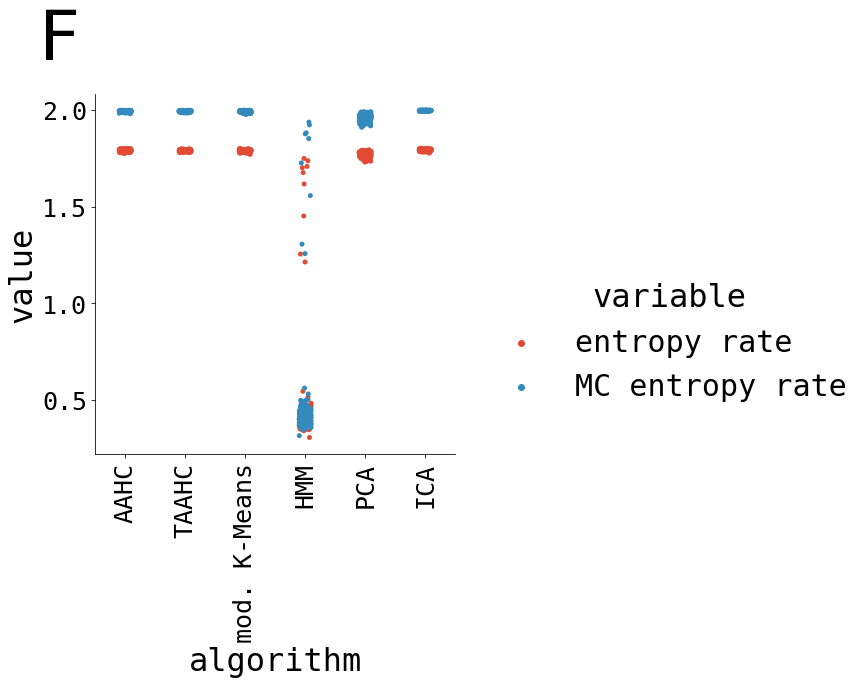

In [12]:
g = sns.catplot(
    data=dynstats.replace({"kmeans": "mod. K-Means"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["entropy rate", "MC entropy rate"],
    ),
    x="algorithm",
    y="value",
    hue="variable",
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "F",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)

g5 = pw.load_seaborngrid(g)
g5.savefig(quick=True)

In [13]:
all_corrs = []
for alg1 in maps["algorithm"]:
    for alg2 in maps["algorithm"]:
        for map1 in maps["latent map"]:
            for map2 in maps["latent map"]:
                corrs = (
                    xr.corr(
                        maps.sel({"algorithm": alg1, "latent map": map1}),
                        maps.sel({"algorithm": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = np.abs(xr.combine_by_coords(all_corrs))

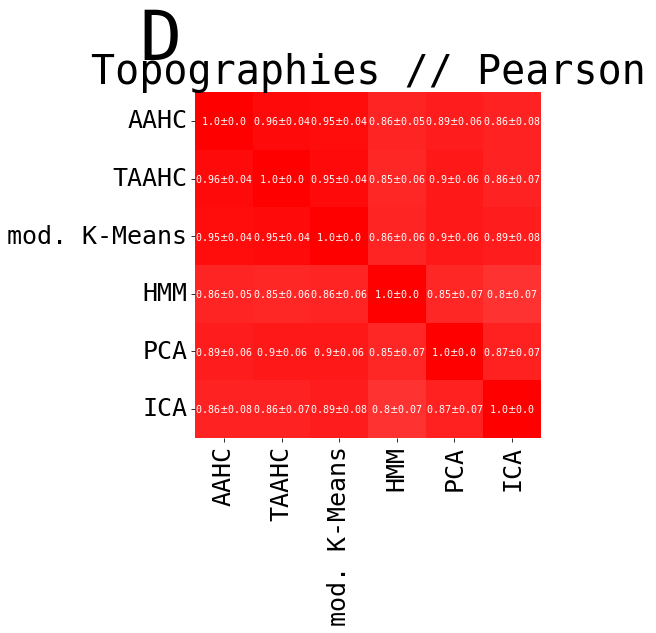

In [14]:
mean = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .mean("subject")
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
mean.index.name = ""
mean.columns = mean.columns.get_level_values(1)
mean.columns.name = ""
mean = mean.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

std = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .std("subject", ddof=1)
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
std.index.name = ""
std.columns = std.columns.get_level_values(1)
std.columns.name = ""
std = std.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

g6 = pw.Brick("ax6", figsize=(6, 6))
sns.heatmap(
    mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=mean.round(2).astype(str) + "$\pm$" + std.round(2).astype(str),
    fmt="",
    ax=g6,
)
g6.set_title("Topographies // Pearson")
g6.text(
    -0.1,
    1.15,
    "D",
    ha="center",
    va="center",
    transform=g6.transAxes,
    fontsize=70,
)
g6.savefig(quick=True)

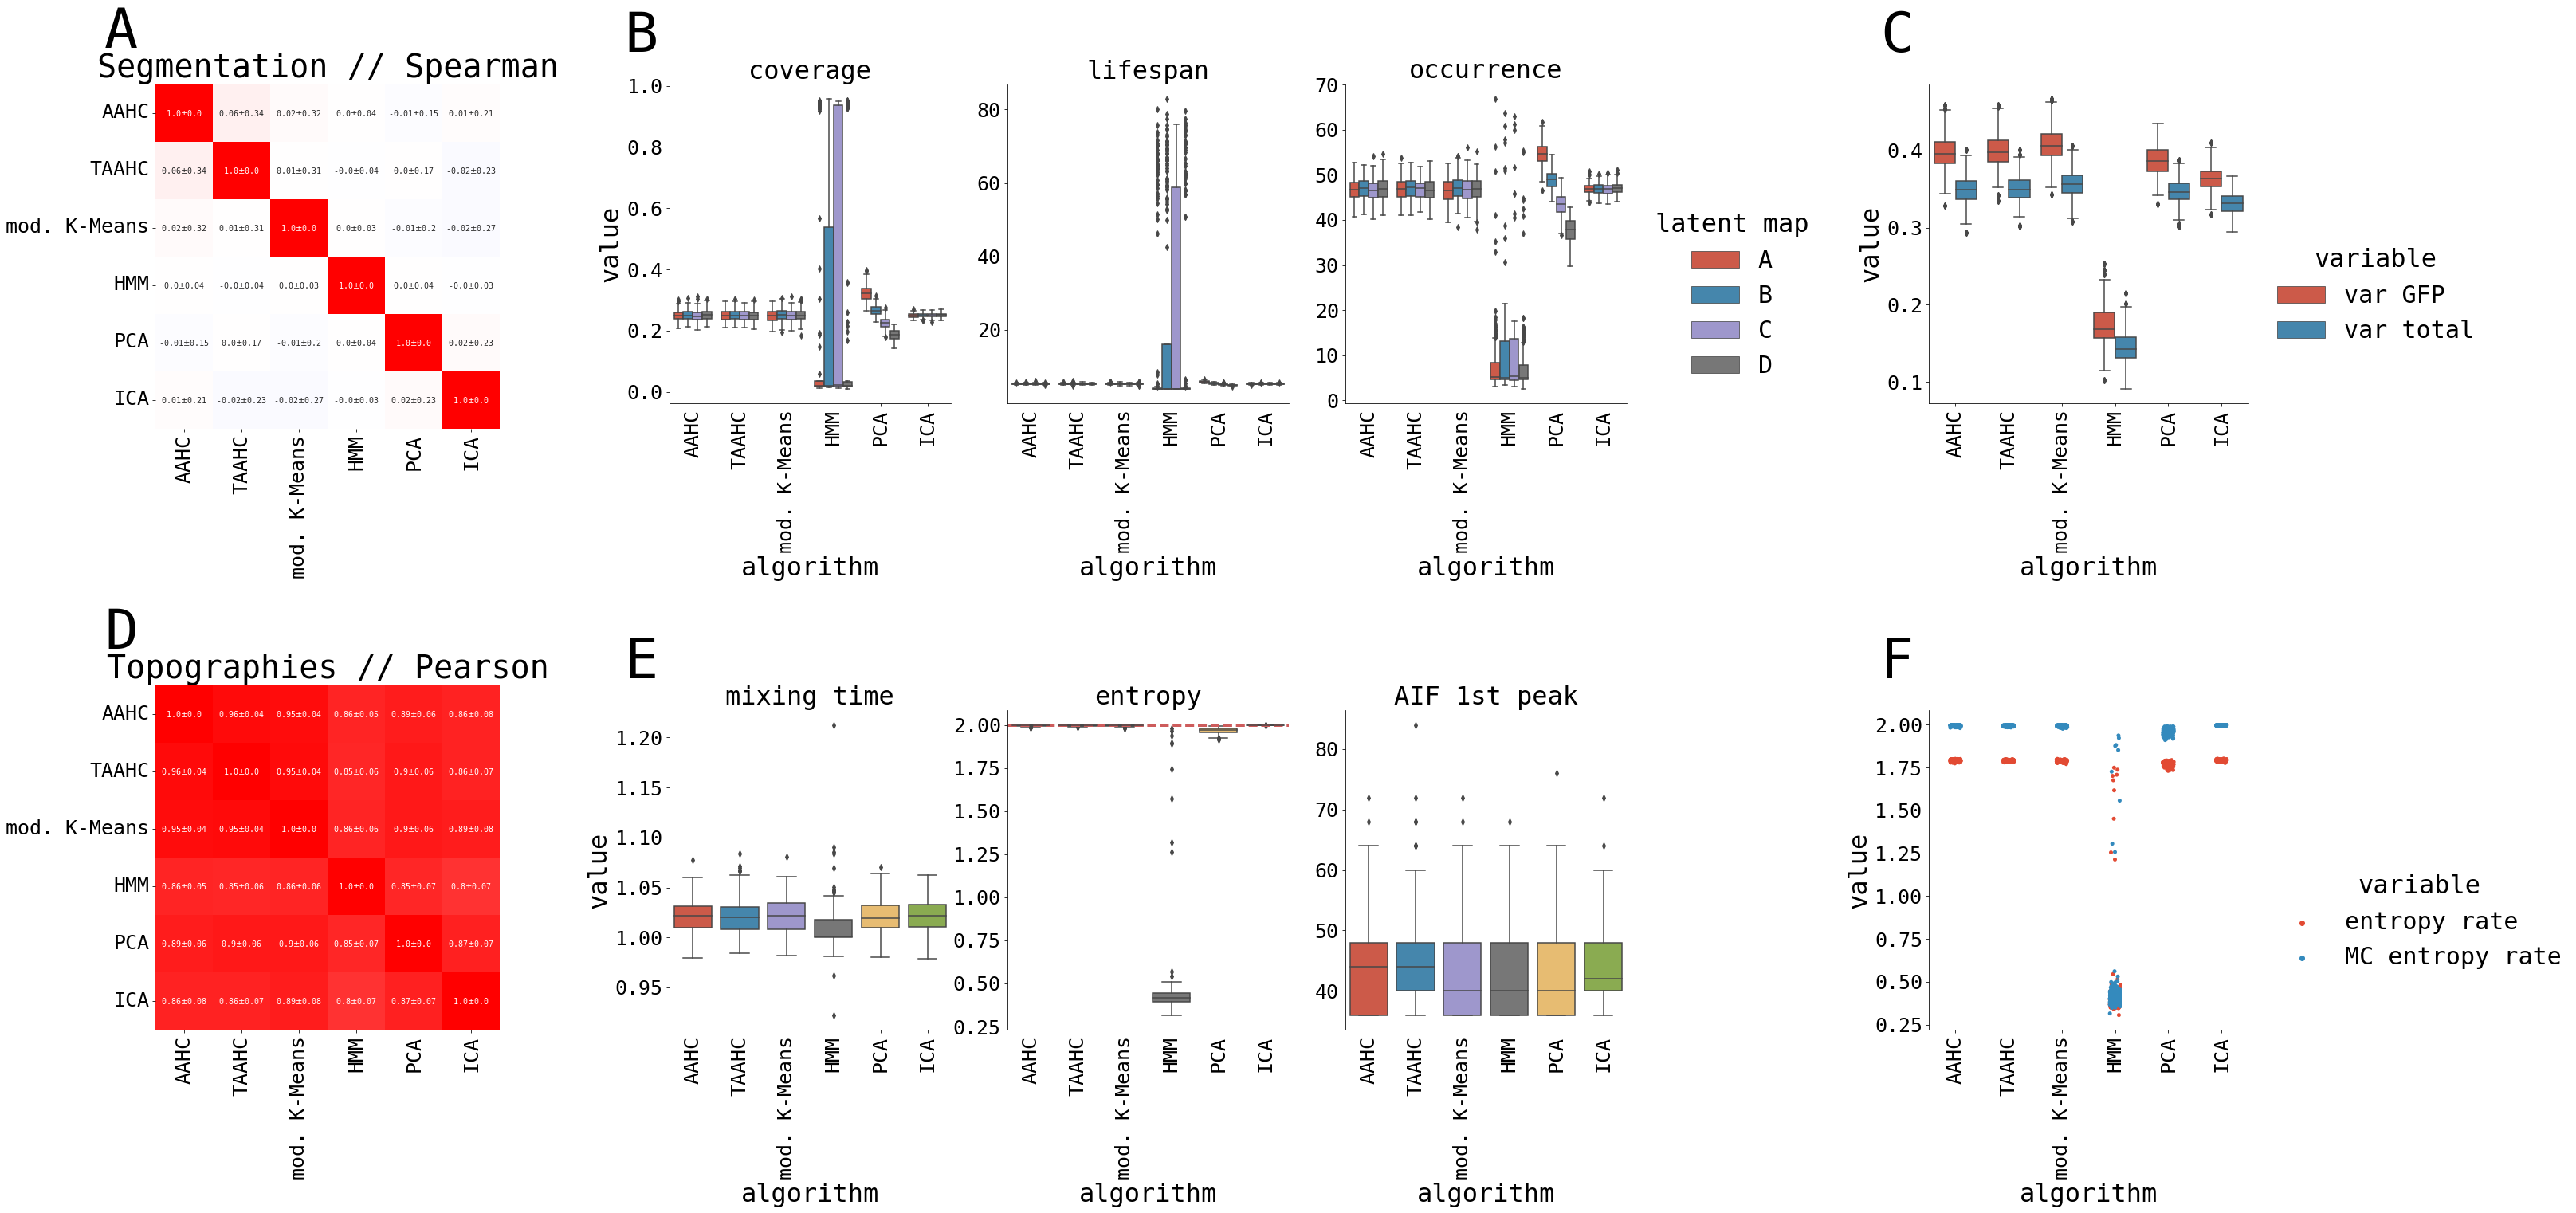

In [15]:
((g1 / g6) | (g2 / g4) | (g3 / g5)).savefig(
    fname="synthetic_subjectwise_stats.pdf", transparent=True
)

In [16]:
mean = (
    all_corrs.where(all_corrs.alg1 == all_corrs.alg2, drop=True)
    .where(all_corrs.map1 != all_corrs.map2)
    .max(["map1", "map2"])
    .mean("subject")
    .to_series()
    .dropna()
    .reset_index()
    .drop("alg2", axis=1)
    .rename(columns={"alg1": "algorithm", 0: "rho"})
    .set_index("algorithm")
)
std = (
    all_corrs.where(all_corrs.alg1 == all_corrs.alg2, drop=True)
    .where(all_corrs.map1 != all_corrs.map2)
    .max(["map1", "map2"])
    .std("subject", ddof=1)
    .to_series()
    .dropna()
    .reset_index()
    .drop("alg2", axis=1)
    .rename(columns={"alg1": "algorithm", 0: "rho"})
    .set_index("algorithm")
)
mean.round(3).astype(str) + " $\pm$ " + std.round(3).astype(str)

,rho
algorithm,
AAHC,0.511 $\pm$ 0.101
HMM,0.72 $\pm$ 0.11
ICA,0.17 $\pm$ 0.054
PCA,0.0 $\pm$ 0.0
TAAHC,0.493 $\pm$ 0.098
kmeans,0.423 $\pm$ 0.102


In [17]:
COLUMNS_ORDER

['AAHC', 'TAAHC', 'mod. K-Means', 'HMM', 'PCA', 'ICA']

In [18]:
RND_SUBJECT = 8
subj_data = data.loc[(f"rnd_subject_{RND_SUBJECT}", slice(None))]
peaks, _ = get_gfp_peaks(
    subj_data.filter(like="chan").values.T,
    min_peak_dist=2,
    smoothing=None,
    smoothing_window=100,
)
subj_data["GFP"] = False
subj_data.iloc[peaks, -1] = True
subj_data

,chan_0,chan_1,chan_2,chan_3,chan_4,chan_5,chan_6,chan_7,chan_8,chan_9,...,chan_17,chan_18,chan_19,PCA,ICA,mod. K-Means,AAHC,TAAHC,HMM,GFP
time,,,,,,,,,,,,,,,,,,,,,
0.000,-3.558802,0.924106,-1.236477,0.070024,-2.302512,0.263465,-2.711569,2.707372,1.873966,-4.112391,...,1.044097,2.286001,1.696565,0,1,0,0,2,2,False
0.004,-4.126889,-3.840936,1.263329,6.583521,-2.805921,-0.134582,6.789029,-2.197926,3.200471,-4.296064,...,0.488070,0.371720,-1.010137,0,1,3,3,0,0,True
0.008,2.674846,-7.846267,1.980992,0.320215,-0.254371,-0.954727,2.978331,1.453164,6.458564,-3.968091,...,-0.180548,-0.467850,3.784864,3,2,0,0,2,0,False
0.012,0.206334,-8.829347,2.571600,6.603337,-6.451496,5.106293,3.789503,2.143484,4.791499,-3.190341,...,-2.075315,-1.005573,-0.743683,3,2,3,3,2,0,False
0.016,4.994651,2.125256,-0.218773,-4.172070,-0.566839,3.102937,-9.418565,1.184571,-5.924680,4.001758,...,0.967235,-1.282843,1.906574,0,1,3,3,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.980,0.679049,-0.329329,1.663981,-3.341006,-1.393573,-4.366136,6.721466,-2.684034,-10.391708,-4.798194,...,6.892068,9.581760,2.494438,1,3,2,0,3,0,False
9.984,-4.864728,-0.941832,4.782556,-0.954591,4.870123,-3.374747,5.203223,-2.605260,2.358781,4.388671,...,2.951151,-2.384597,-1.094563,2,0,3,2,0,0,False
9.988,-3.351259,0.840395,0.155571,-7.163854,2.172676,-0.482140,3.669040,-1.674319,-0.031029,4.937484,...,-4.069846,5.530846,-2.981881,3,2,2,0,3,0,False


In [19]:
legend = {2: 0, 3: 1, 4: 1, 5: 2}


def get_pca(algo, n_comps=5):
    pca = PCA(n_components=n_comps)
    pca_data = subj_data[subj_data["GFP"]].filter(like="chan")
    pcs = pca.fit_transform(pca_data.values)
    pcs = pd.DataFrame(
        pcs, columns=[f"PC {i}" for i in range(n_comps)], index=pca_data.index
    )
    pcs[algo] = subj_data[subj_data["GFP"]][algo]

    g = sns.PairGrid(pcs, vars=[f"PC {i}" for i in range(n_comps)], hue=algo)
    g.map_diag(sns.histplot, bins=30, alpha=0.5)
    g.map_offdiag(sns.scatterplot)
    g.axes[0, legend[n_comps]].set_title(algo)

    return g


def get_tsne(algo, n_comps=5):
    pca = TSNE(n_components=n_comps, init="pca", n_jobs=6, method="exact")
    pca_data = subj_data[subj_data["GFP"]].filter(like="chan")
    pcs = pca.fit_transform(pca_data.values)
    pcs = pd.DataFrame(
        pcs, columns=[f"t-SNE {i}" for i in range(n_comps)], index=pca_data.index
    )
    pcs[algo] = subj_data[subj_data["GFP"]][algo]

    g = sns.PairGrid(pcs, vars=[f"t-SNE {i}" for i in range(n_comps)], hue=algo)
    g.map_diag(sns.histplot, bins=30, alpha=0.5)
    g.map_offdiag(sns.scatterplot)
    g.axes[0, legend[n_comps]].set_title(algo)

    return g


def get_ica(algo, n_comps=5):
    pca = FastICA(n_components=n_comps)
    pca_data = subj_data[subj_data["GFP"]].filter(like="chan")
    pcs = pca.fit_transform(pca_data.values)
    pcs = pd.DataFrame(
        pcs, columns=[f"ICA {i}" for i in range(n_comps)], index=pca_data.index
    )
    pcs[algo] = subj_data[subj_data["GFP"]][algo]

    g = sns.PairGrid(pcs, vars=[f"ICA {i}" for i in range(n_comps)], hue=algo)
    g.map_diag(sns.histplot, bins=30, alpha=0.5)
    g.map_offdiag(sns.scatterplot)
    g.axes[0, legend[n_comps]].set_title(algo)

    return g

In [20]:
for comps in tqdm(range(2, 6)):
    g10 = pw.load_seaborngrid(get_pca("AAHC", n_comps=comps))
    g11 = pw.load_seaborngrid(get_pca("TAAHC", n_comps=comps))
    g12 = pw.load_seaborngrid(get_pca("mod. K-Means", n_comps=comps))
    g13 = pw.load_seaborngrid(get_pca("HMM", n_comps=comps))
    g14 = pw.load_seaborngrid(get_pca("PCA", n_comps=comps))
    g15 = pw.load_seaborngrid(get_pca("ICA", n_comps=comps))
    ((g10 | g11 | g12) / (g13 | g14 | g15)).savefig(
        fname=f"single_subj_synthetic_GFP_PCA_lowdim_{comps}.png", transparent=False
    )

    g10 = pw.load_seaborngrid(get_tsne("AAHC", n_comps=comps))
    g11 = pw.load_seaborngrid(get_tsne("TAAHC", n_comps=comps))
    g12 = pw.load_seaborngrid(get_tsne("mod. K-Means", n_comps=comps))
    g13 = pw.load_seaborngrid(get_tsne("HMM", n_comps=comps))
    g14 = pw.load_seaborngrid(get_tsne("PCA", n_comps=comps))
    g15 = pw.load_seaborngrid(get_tsne("ICA", n_comps=comps))
    ((g10 | g11 | g12) / (g13 | g14 | g15)).savefig(
        fname=f"single_subj_synthetic_GFP_tSNE_lowdim_{comps}.png", transparent=False
    )

    g10 = pw.load_seaborngrid(get_ica("AAHC", n_comps=comps))
    g11 = pw.load_seaborngrid(get_ica("TAAHC", n_comps=comps))
    g12 = pw.load_seaborngrid(get_ica("mod. K-Means", n_comps=comps))
    g13 = pw.load_seaborngrid(get_ica("HMM", n_comps=comps))
    g14 = pw.load_seaborngrid(get_ica("PCA", n_comps=comps))
    g15 = pw.load_seaborngrid(get_ica("ICA", n_comps=comps))
    ((g10 | g11 | g12) / (g13 | g14 | g15)).savefig(
        fname=f"single_subj_synthetic_GFP_ICA_lowdim_{comps}.png", transparent=False
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [14:25<00:00, 216.46s/it]


In [21]:
# def get_pca(decomp, n_comps=2):
#     pca = PCA(n_components=n_comps)
#     pcs = pca.fit_transform(
#         maps.stack(samples=("subject", "latent map"))
#         .sel({"algorithm": decomp})
#         .values.T
#     )
#     low_dim = pd.DataFrame(pcs, columns=[f"PC {i}" for i in range(n_comps)])
#     low_dim["map"] = maps.stack(samples=("subject", "latent map")).sel(
#         {"algorithm": decomp}
#     )["latent map"]
#     g = sns.PairGrid(low_dim, vars=[f"PC {i}" for i in range(n_comps)], hue="map")
#     g.map_diag(sns.histplot, bins=30, alpha=0.5)
#     g.map_offdiag(sns.scatterplot)
#     g.axes[0, 0].set_title(decomp)
#     return g


# def get_tsne(decomp, n_comps=2):
#     tsne = TSNE(n_components=n_comps, init="pca", n_jobs=6, method="exact")
#     pcs = tsne.fit_transform(
#         maps.stack(samples=("subject", "latent map"))
#         .sel({"algorithm": decomp})
#         .values.T
#     )
#     low_dim = pd.DataFrame(pcs, columns=[f"t-SNE {i}" for i in range(n_comps)])
#     low_dim["map"] = maps.stack(samples=("subject", "latent map")).sel(
#         {"algorithm": decomp}
#     )["latent map"]
#     g = sns.PairGrid(low_dim, vars=[f"t-SNE {i}" for i in range(n_comps)], hue="map")
#     g.map_diag(sns.histplot, bins=30, alpha=0.5)
#     g.map_offdiag(sns.scatterplot)
#     return g


# def get_mds(decomp, n_comps=2):
#     mds = MDS(n_components=n_comps, n_jobs=6)
#     pcs = mds.fit_transform(
#         maps.stack(samples=("subject", "latent map"))
#         .sel({"algorithm": decomp})
#         .values.T
#     )
#     low_dim = pd.DataFrame(pcs, columns=[f"MDS {i}" for i in range(n_comps)])
#     low_dim["map"] = maps.stack(samples=("subject", "latent map")).sel(
#         {"algorithm": decomp}
#     )["latent map"]
#     g = sns.PairGrid(low_dim, vars=[f"MDS {i}" for i in range(n_comps)], hue="map")
#     g.map_diag(sns.histplot, bins=30, alpha=0.5)
#     g.map_offdiag(sns.scatterplot)
#     return g


# def get_lle(decomp, n_comps=2):
#     lle = LocallyLinearEmbedding(n_components=n_comps, n_neighbors=10, n_jobs=6)
#     pcs = lle.fit_transform(
#         maps.stack(samples=("subject", "latent map"))
#         .sel({"algorithm": decomp})
#         .values.T
#     )
#     low_dim = pd.DataFrame(pcs, columns=[f"LLE {i}" for i in range(n_comps)])
#     low_dim["map"] = maps.stack(samples=("subject", "latent map")).sel(
#         {"algorithm": decomp}
#     )["latent map"]
#     g = sns.PairGrid(low_dim, vars=[f"LLE {i}" for i in range(n_comps)], hue="map")
#     g.map_diag(sns.histplot, bins=30, alpha=0.5)
#     g.map_offdiag(sns.scatterplot)
#     return g


# maps["algorithm"] = ["AAHC", "HMM", "ICA", "PCA", "TAAHC", "mod. K-Means"]
# N_COMPS = 4

# g = get_pca("AAHC", n_comps=N_COMPS)
# # g.ax_marg_x.text(
# #     0.0,
# #     0.9,
# #     "G",
# #     ha="center",
# #     va="center",
# #     transform=g.ax_marg_x.transAxes,
# #     fontsize=90,
# # )
# g10 = pw.load_seaborngrid(g)
# g11 = pw.load_seaborngrid(get_pca("TAAHC", n_comps=N_COMPS))
# g12 = pw.load_seaborngrid(get_pca("mod. K-Means", n_comps=N_COMPS))
# g13 = pw.load_seaborngrid(get_pca("HMM", n_comps=N_COMPS))
# g14 = pw.load_seaborngrid(get_pca("PCA", n_comps=N_COMPS))
# g15 = pw.load_seaborngrid(get_pca("ICA", n_comps=N_COMPS))

# g20 = pw.load_seaborngrid(get_tsne("AAHC", n_comps=N_COMPS))
# g21 = pw.load_seaborngrid(get_tsne("TAAHC", n_comps=N_COMPS))
# g22 = pw.load_seaborngrid(get_tsne("mod. K-Means", n_comps=N_COMPS))
# g23 = pw.load_seaborngrid(get_tsne("HMM", n_comps=N_COMPS))
# g24 = pw.load_seaborngrid(get_tsne("PCA", n_comps=N_COMPS))
# g25 = pw.load_seaborngrid(get_tsne("ICA", n_comps=N_COMPS))

# g30 = pw.load_seaborngrid(get_mds("AAHC", n_comps=N_COMPS))
# g31 = pw.load_seaborngrid(get_mds("TAAHC", n_comps=N_COMPS))
# g32 = pw.load_seaborngrid(get_mds("mod. K-Means", n_comps=N_COMPS))
# g33 = pw.load_seaborngrid(get_mds("HMM", n_comps=N_COMPS))
# g34 = pw.load_seaborngrid(get_mds("PCA", n_comps=N_COMPS))
# g35 = pw.load_seaborngrid(get_mds("ICA", n_comps=N_COMPS))

# g40 = pw.load_seaborngrid(get_lle("AAHC", n_comps=N_COMPS))
# g41 = pw.load_seaborngrid(get_lle("TAAHC", n_comps=N_COMPS))
# g42 = pw.load_seaborngrid(get_lle("mod. K-Means", n_comps=N_COMPS))
# g43 = pw.load_seaborngrid(get_lle("HMM", n_comps=N_COMPS))
# g44 = pw.load_seaborngrid(get_lle("PCA", n_comps=N_COMPS))
# g45 = pw.load_seaborngrid(get_lle("ICA", n_comps=N_COMPS))

In [22]:
# (
#     (g10 | g11 | g12 | g13 | g14 | g15)
#     / (g20 | g21 | g22 | g23 | g24 | g25)
#     / (g30 | g31 | g32 | g33 | g34 | g35)
#     / (g40 | g41 | g42 | g43 | g44 | g45)
# ).savefig(fname="all_subjects_synthetic_topomaps_lowdim.png")